<a href="https://colab.research.google.com/github/asma-walha/Machine-Learning/blob/main/Cancer_de_la_peau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Loading

In [130]:
!pip install -q kaggle

from google.colab import files
files.upload()  # Upload kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip -q skin-cancer-mnist-ham10000.zip -d skin-cancer


Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
User cancelled operation
replace skin-cancer/HAM10000_images_part_1/ISIC_0024306.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import seaborn as sns

import cv2
import numpy as np
from skimage.feature import local_binary_pattern, hog
from skimage.filters import gabor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from skimage.feature import graycomatrix, graycoprops

In [86]:
RAW_DATA_BASE_PATH="skin-cancer"
metadata_path = os.path.join(RAW_DATA_BASE_PATH, "HAM10000_metadata.csv")
df_meta = None
sample_image_paths = []

if os.path.exists(metadata_path):
    df_meta = pd.read_csv(metadata_path)
    print(f"Loaded metadata: {df_meta.shape[0]} records.")

    # Construct full image paths
    image_part1_dir = os.path.join(RAW_DATA_BASE_PATH, "HAM10000_images_part_1")
    image_part2_dir = os.path.join(RAW_DATA_BASE_PATH, "HAM10000_images_part_2")
    imageid_to_path = {}
    for img_dir in [image_part1_dir, image_part2_dir]:
        if os.path.exists(img_dir):
            for fname in os.listdir(img_dir):
                if fname.endswith(".jpg"):
                    imageid_to_path[os.path.splitext(fname)[0]] = os.path.join(img_dir, fname)
        else:
            print(f"Warning: Image directory not found: {img_dir}")

    df_meta['full_path'] = df_meta['image_id'].map(imageid_to_path)
    df_meta.dropna(subset=['full_path'], inplace=True) # Keep only images we found
    NUM_SAMPLES_TO_SHOW= 5
    if len(df_meta) >= NUM_SAMPLES_TO_SHOW:
        sample_image_paths = df_meta['full_path'].sample(NUM_SAMPLES_TO_SHOW, random_state=42).tolist()
        print(f"\nSelected {NUM_SAMPLES_TO_SHOW} sample image paths for experimentation.")
    elif len(df_meta) > 0:
        sample_image_paths = df_meta['full_path'].tolist()
        print(f"\nSelected all {len(df_meta)} available image paths for experimentation (fewer than desired {NUM_SAMPLES_TO_SHOW}).")
    else:
        print("No image paths found after linking with metadata.")
else:
    print(f"ERROR: Metadata file not found at {metadata_path}. Cannot proceed.")


Loaded metadata: 10015 records.

Selected 5 sample image paths for experimentation.


#Data Exploration

In [87]:

print("----df columns----")
print(df_meta.columns)

print("----df[dx]----")

dx_info = {
    'nv':     ['Melanocytic nevus',                    'Benign'],
    'mel':    ['Melanoma',                             'Malignant'],
    'bkl':    ['Benign keratosis-like lesions',        'Benign'],
    'bcc':    ['Basal cell carcinoma',                 'Malignant'],
    'akiec':  ['Actinic keratoses / Bowen’s disease',  'Malignant'],
    'vasc':   ['Vascular lesions',                     'Benign'],
    'df':     ['Dermatofibroma',                       'Benign']
}

dx_counts = df_meta['dx'].value_counts().rename_axis('dx').reset_index(name='Count')

dx_counts['Full Name'] = dx_counts['dx'].apply(lambda x: dx_info[x][0])
dx_counts['Type'] = dx_counts['dx'].apply(lambda x: dx_info[x][1])

dx_table = dx_counts[['dx', 'Full Name', 'Type', 'Count']]

print(dx_table.to_string(index=False))


----df columns----
Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'full_path'],
      dtype='object')
----df[dx]----
   dx                           Full Name      Type  Count
   nv                   Melanocytic nevus    Benign   6705
  mel                            Melanoma Malignant   1113
  bkl       Benign keratosis-like lesions    Benign   1099
  bcc                Basal cell carcinoma Malignant    514
akiec Actinic keratoses / Bowen’s disease Malignant    327
 vasc                    Vascular lesions    Benign    142
   df                      Dermatofibroma    Benign    115


In [91]:
df_meta['malade'] = df_meta['dx'].apply(lambda x: 1 if x in ['mel', 'bcc', 'akiec'] else 0)

#Data Exploration (Additional)

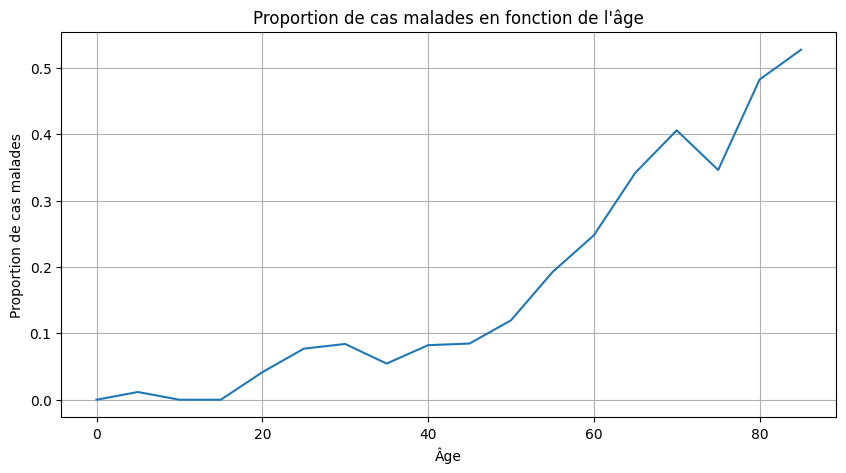

In [4]:
df_age = df_meta.dropna(subset=['age'])

age_group = df_age.groupby('age')['malade'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=age_group, x='age', y='malade')
plt.title("Proportion de cas malades en fonction de l'âge")
plt.xlabel("Âge")
plt.ylabel("Proportion de cas malades")
plt.grid(True)
plt.show()


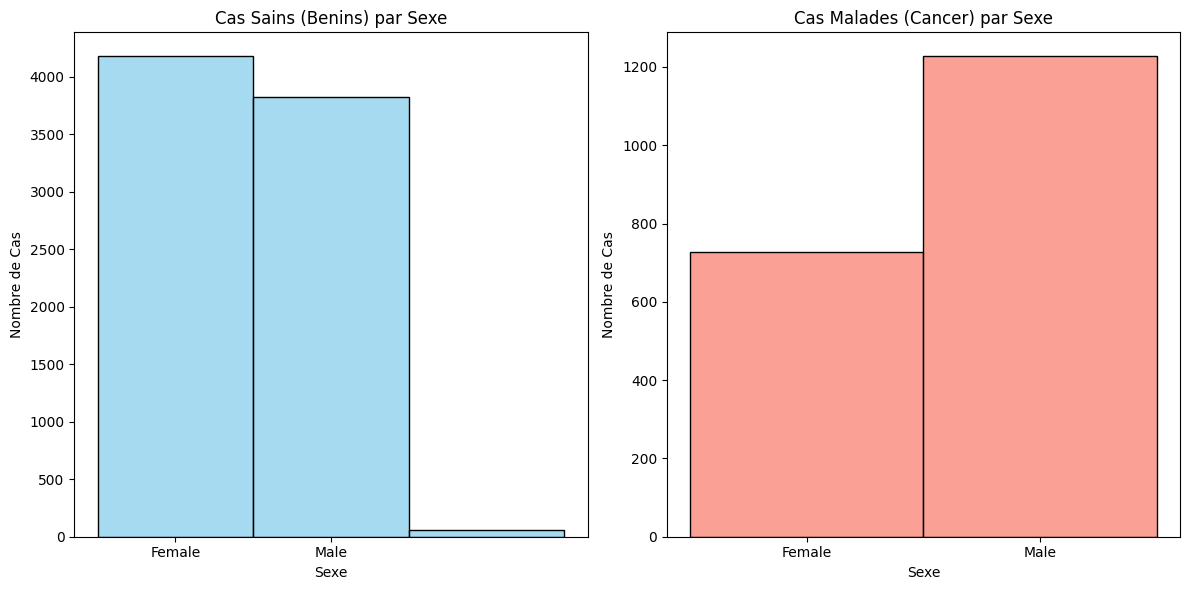

In [5]:
df_sain = df_meta[df_meta['malade'] == 0]
df_malade = df_meta[df_meta['malade'] == 1]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # (ligne, colonne, position)
sns.histplot(df_sain['sex'], kde=False, bins=2, color='skyblue', discrete=True)
plt.title("Cas Sains (Benins) par Sexe")
plt.xlabel("Sexe")
plt.ylabel("Nombre de Cas")
plt.xticks([0, 1], ['Female', 'Male'])

plt.subplot(1, 2, 2)
sns.histplot(df_malade['sex'], kde=False, bins=2, color='salmon', discrete=True)
plt.title("Cas Malades (Cancer) par Sexe")
plt.xlabel("Sexe")
plt.ylabel("Nombre de Cas")
plt.xticks([0, 1], ['Female', 'Male'])

plt.tight_layout()
plt.show()


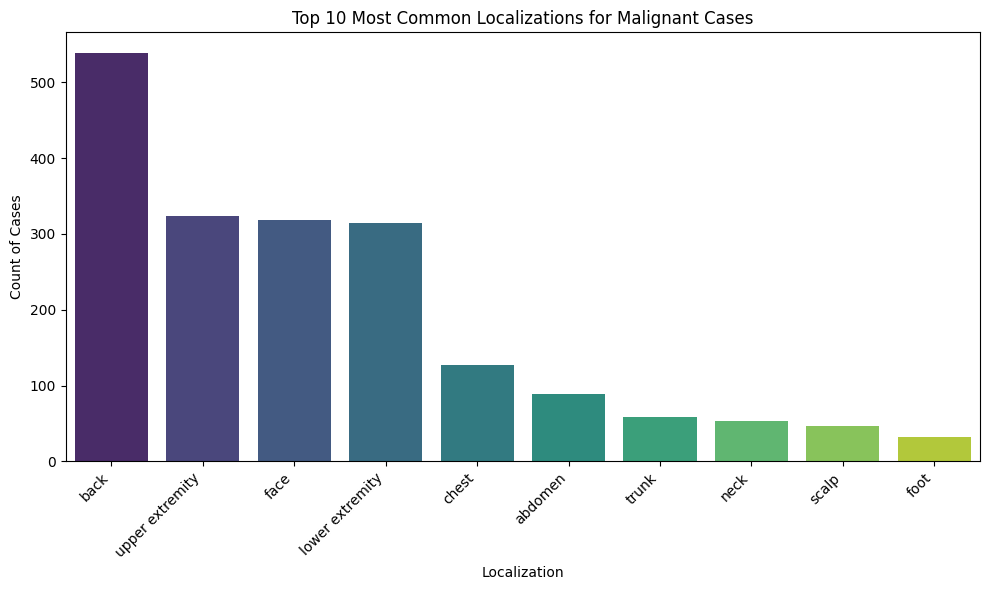

In [6]:
# Get the top 10 most common body locations for malignant cases
top_10_localizations = df_malade['localization'].value_counts().head(10)

local_df = top_10_localizations.reset_index()
local_df.columns = ['localization', 'count']

plt.figure(figsize=(10, 6))
sns.barplot(data=local_df, x='localization', y='count', hue='localization', palette='viridis', legend=False)

plt.title("Top 10 Most Common Localizations for Malignant Cases")
plt.xlabel("Localization")
plt.ylabel("Count of Cases")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#Data Visualisation

In [23]:
TARGET_SIZE = (224, 224) # Target size for resizing images (e.g., for consistency or model input)
TARGET_COLOR_SPACE = 'GRAY'

def load_image(image_path):
    """Loads an image using OpenCV in BGR format."""
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Could not load image at {image_path}")
    return img

def display_image(image, title="Image", cmap=None):
    """Displays an OpenCV image (handles BGR to RGB for color)."""
    if image is None:
        print("Cannot display a None image.")
        return
    plt.figure(figsize=(9, 3))
    if len(image.shape) == 3 and image.shape[2] == 3: # Color
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    elif len(image.shape) == 2 or (len(image.shape) == 3 and image.shape[2] == 1): # Grayscale
        plt.imshow(image, cmap='gray' if cmap is None else cmap)
    else:
        print(f"Unsupported image shape for display: {image.shape}")
        return
    plt.title(title)
    plt.axis('off')
    plt.show()

def image_details(sample_img):
    diagnosis = f"{sample_img['dx']} ({'Malignant' if sample_img['malade'] else 'Benign'})"
    print("\nImage Details:")
    print(f"Image ID: {sample_img['image_id']}")
    print(f"Diagnosis: {diagnosis}")
    print(f"Age: {sample_img['age']}")
    print(f"Sex: {sample_img['sex']}")
    print(f"Localization: {sample_img['localization']}")

def save_image(image_path, image_data):
    """Saves an image using OpenCV."""
    try:
        cv2.imwrite(image_path, image_data)
        # print(f"Saved: {image_path}")
    except Exception as e:
        print(f"Error saving image {image_path}: {e}")

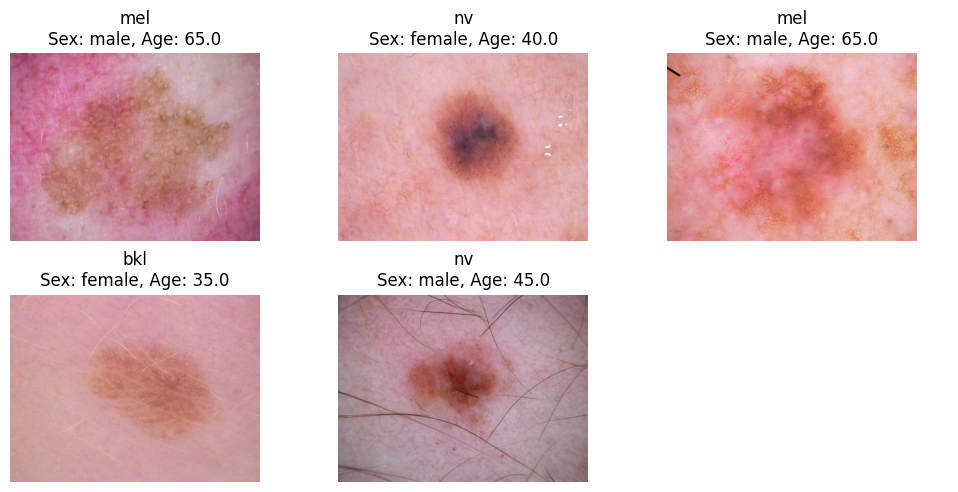

In [131]:
# Set layout
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(10, 5))  # Adjust size as needed
axes = axes.flatten()  # Flatten for easy indexing

# Iterate through samples
for i, img_path in enumerate(sample_image_paths[:rows * cols]):  # Max 6 images
    img = load_image(img_path)
    if img is None:
        continue

    image_id = os.path.splitext(os.path.basename(img_path))[0]
    row = df_meta[df_meta['image_id'] == image_id].iloc[0]
    sex = row['sex']
    age = row['age']
    localization = row['localization']
    diagnosis = row['dx']
    malade = row.get('malade', False)

    # Display image
    ax = axes[i]
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    ax.set_title(f"{diagnosis}\nSex: {sex}, Age: {age}")

# If fewer than 6, turn off extra axes
for j in range(i + 1, rows * cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


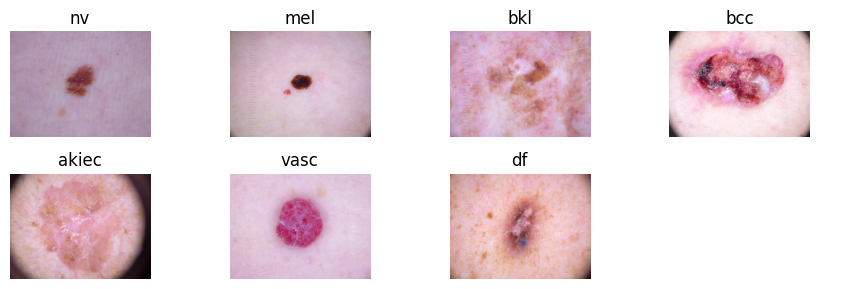

In [9]:
plt.figure(figsize=(9, 3))  # Create one figure for all subplots
j = 0

for i in dx_info.keys():
    sample_img = df_meta[df_meta['dx'] == i].iloc[0]
    image_id = sample_img['image_id']

    # Look in part 1 and part 2
    sample_image_path = f"skin-cancer/HAM10000_images_part_1/{image_id}.jpg"
    if not os.path.exists(sample_image_path):
        sample_image_path = f"skin-cancer/HAM10000_images_part_2/{image_id}.jpg"

    img = load_image(sample_image_path)
    if img is None:
        continue

    j += 1
    plt.subplot(2, 4, j)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert from BGR to RGB
    plt.title(i)
    plt.axis("off")

# Optional: turn off the empty 8th subplot
if j < 8:
    for k in range(j + 1, 9):
        plt.subplot(2, 4, k)
        plt.axis("off")

plt.tight_layout()
plt.show()


# Image Processing

In [127]:

# --- Preprocessing Function ---
def preprocess_image(img, target_size=None, target_color_space='GRAY'):
    """
    Applies a series of preprocessing steps to an image.
    """
    if img is None:
        return None

    processed_img = img.copy()

    # 1. Resizing (Optional)
    if target_size:
        color_processed_img = cv2.resize(processed_img, target_size, interpolation=cv2.INTER_AREA)

    # 2. Color Space Conversion
    if target_color_space == 'GRAY':
        if len(color_processed_img.shape) == 3 and color_processed_img.shape[2] == 3: # If it's a color image
            grey_processed_img = cv2.cvtColor(color_processed_img, cv2.COLOR_BGR2GRAY)
    elif target_color_space == 'RGB':
        # OpenCV loads as BGR. If we want to work with RGB internally (e.g. for Pillow or some models)
        # we might convert here, but usually, we keep it BGR for OpenCV functions
        # and convert to RGB only for display with Matplotlib.
        # For simplicity, if 'RGB' is chosen, we assume it's already BGR and fine for OpenCV.
        pass
    elif target_color_space == 'HSV':
        if len(color_processed_img.shape) == 3 and color_processed_img.shape[2] == 3:
            grey_processed_img = cv2.cvtColor(color_processed_img, cv2.COLOR_BGR2HSV)
    # Add other color spaces if needed (e.g., LAB)

    # 3. Noise Reduction (Example: Gaussian Blur or Median Blur)
    # Gaussian Blur: Good for general noise. Kernel size must be odd.
    grey_processed_img = cv2.GaussianBlur(grey_processed_img, (5, 5), 0)
    # Median Blur: Good for salt-and-pepper noise. Kernel size must be odd.
    # grey_processed_img = cv2.medianBlur(grey_processed_img, 5)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    grey_processed_img = clahe.apply(grey_processed_img)

    # 5. segmentation par seuillage d’Otsu
    _, mask = cv2.threshold(grey_processed_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    inversed_mask = cv2.bitwise_not(mask)

    # 7. Remove dark corners using circular mask
    h, w = inversed_mask.shape
    center = (w // 2, h // 2)
    radius = min(center[0], center[1], w - center[0], h - center[1]) - 10  # 10-pixel margin
    circular_mask = np.zeros_like(inversed_mask)
    cv2.circle(circular_mask, center, radius, 255, -1)  # White circle on black
    inversed_mask = cv2.bitwise_and(inversed_mask, circular_mask)

    # 8. Morphological improvement
    kernel = np.ones((3, 3), np.uint8)
    inversed_mask = cv2.morphologyEx(inversed_mask, cv2.MORPH_CLOSE, kernel)
    inversed_mask = cv2.morphologyEx(inversed_mask, cv2.MORPH_OPEN, kernel)

    segmented_color = cv2.bitwise_and(color_processed_img, color_processed_img, mask=inversed_mask)

    return grey_processed_img , segmented_color, inversed_mask

In [126]:
# --- Visualisation Processed Images ---

def visualize_results(sample_img):
    """Visualizes the preprocessing and segmentation results."""
    sample_image_path = f"skin-cancer/HAM10000_images_part_1/{sample_img['image_id']}.jpg"
    if not os.path.exists(sample_image_path):
        sample_image_path = f"skin-cancer/HAM10000_images_part_2/{sample_img['image_id']}.jpg"

    # Load and process image
    img = load_image(sample_image_path)
    if img is not None:
        grey_processed_img, segmented_color, mask = preprocess_image(
            img,
            target_size=TARGET_SIZE,
            target_color_space=TARGET_COLOR_SPACE
        )

        # Visualize results
        diagnosis = f"{sample_img['dx']} ({'Malignant' if sample_img['malade'] else 'Benign'})"
        image_details(sample_img)

        plt.figure(figsize=(9, 3))

        # Original Image
        plt.subplot(1, 4, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Original Image\nDiagnosis: {diagnosis}")
        plt.axis("off")

        # Grey Processed
        plt.subplot(1, 4, 2)
        plt.imshow(grey_processed_img, cmap='gray')
        plt.title("Grayscale Processed")
        plt.axis("off")

        # Color Segmented
        plt.subplot(1, 4, 3)
        if len(segmented_color.shape) == 3:  # Color image
            plt.imshow(cv2.cvtColor(segmented_color, cv2.COLOR_BGR2RGB))
        else:  # Grayscale
            plt.imshow(segmented_color, cmap='gray')
        plt.title("Segmented Color")
        plt.axis("off")

        # Mask
        plt.subplot(1, 4, 4)
        plt.imshow(mask, cmap='gray')
        plt.title("Lesion Mask")
        plt.axis("off")

        plt.tight_layout()
        plt.show()


Image Details:
Image ID: ISIC_0033272
Diagnosis: mel (Malignant)
Age: 65.0
Sex: male
Localization: face


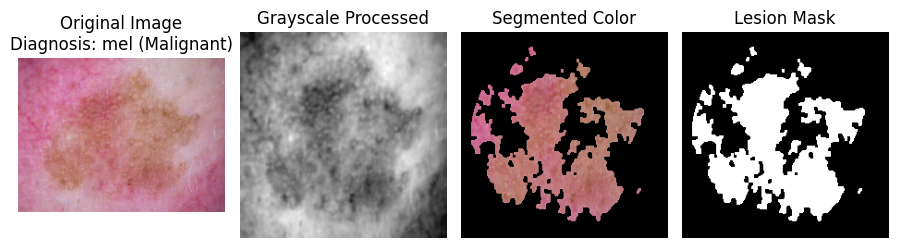


Image Details:
Image ID: ISIC_0033272
Diagnosis: mel (Malignant)
Age: 65.0
Sex: male
Localization: face

Image Details:
Image ID: ISIC_0031923
Diagnosis: nv (Benign)
Age: 40.0
Sex: female
Localization: lower extremity


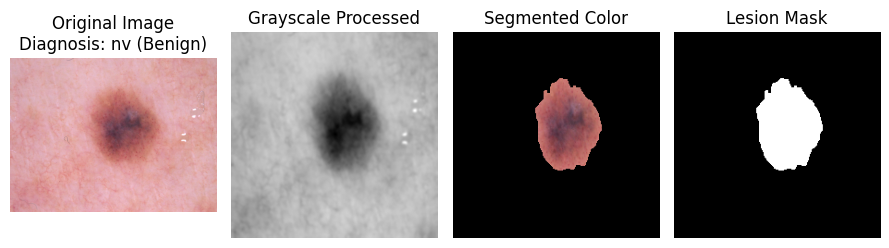


Image Details:
Image ID: ISIC_0031923
Diagnosis: nv (Benign)
Age: 40.0
Sex: female
Localization: lower extremity

Image Details:
Image ID: ISIC_0026652
Diagnosis: mel (Malignant)
Age: 65.0
Sex: male
Localization: back


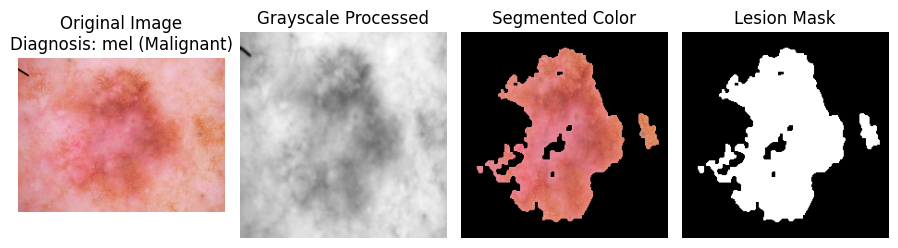


Image Details:
Image ID: ISIC_0026652
Diagnosis: mel (Malignant)
Age: 65.0
Sex: male
Localization: back

Image Details:
Image ID: ISIC_0030583
Diagnosis: bkl (Benign)
Age: 35.0
Sex: female
Localization: trunk


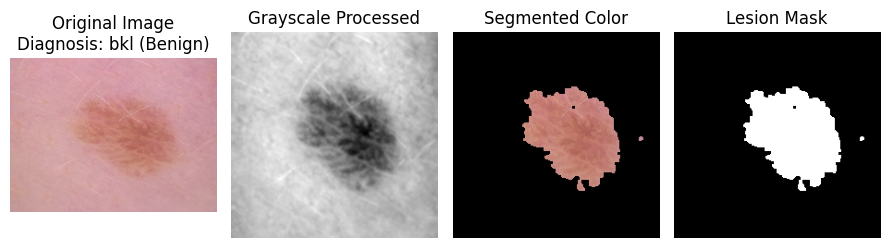


Image Details:
Image ID: ISIC_0030583
Diagnosis: bkl (Benign)
Age: 35.0
Sex: female
Localization: trunk

Image Details:
Image ID: ISIC_0034010
Diagnosis: nv (Benign)
Age: 45.0
Sex: male
Localization: abdomen


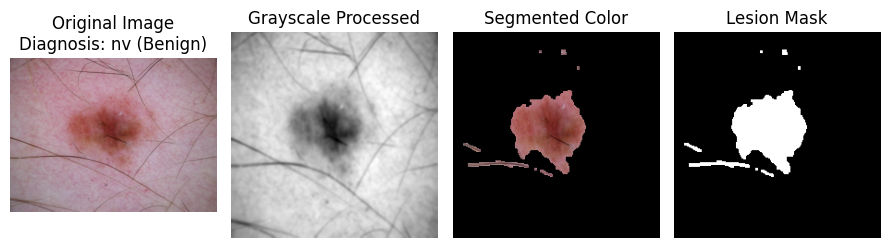


Image Details:
Image ID: ISIC_0034010
Diagnosis: nv (Benign)
Age: 45.0
Sex: male
Localization: abdomen


In [98]:
#-------Test on our Samples-------------
for img_path in sample_image_paths:
    # Load image
    img = load_image(img_path)
    if img is None:
        continue  # Skip if image couldn't be loaded

    # Preprocess
    grey_img, segmented_color, mask = preprocess_image(
        img,
        target_size=TARGET_SIZE,
        target_color_space=TARGET_COLOR_SPACE
    )

    # Get metadata info for display
    image_id = os.path.splitext(os.path.basename(img_path))[0]
    sample_info = df_meta[df_meta['image_id'] == image_id].iloc[0]
    diagnosis = f"{sample_info['dx']} ({'Malignant' if sample_info['malade'] else 'Benign'})"

    # Visualize
    visualize_results(sample_info)

    # Optionally, print details
    image_details(sample_info)




Image Details:
Image ID: ISIC_0033272
Diagnosis: mel (Malignant)
Age: 65.0
Sex: male
Localization: face


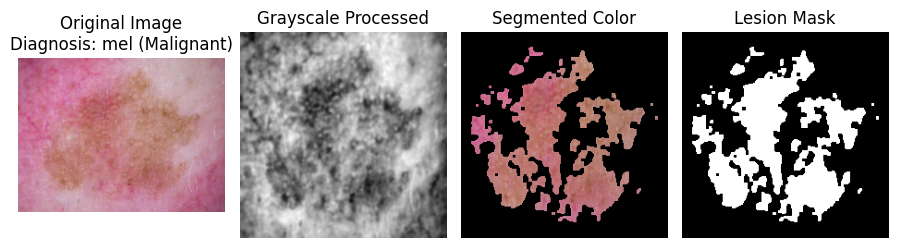


Image Details:
Image ID: ISIC_0033272
Diagnosis: mel (Malignant)
Age: 65.0
Sex: male
Localization: face

Image Details:
Image ID: ISIC_0031923
Diagnosis: nv (Benign)
Age: 40.0
Sex: female
Localization: lower extremity


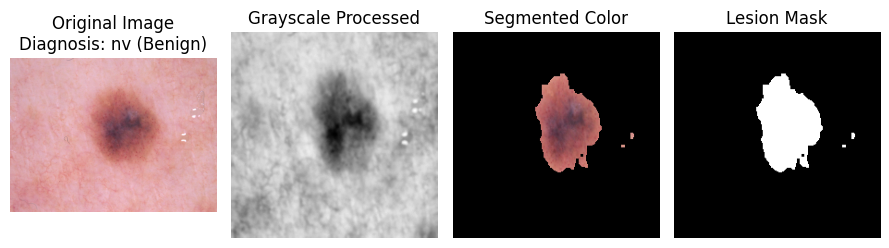


Image Details:
Image ID: ISIC_0031923
Diagnosis: nv (Benign)
Age: 40.0
Sex: female
Localization: lower extremity

Image Details:
Image ID: ISIC_0026652
Diagnosis: mel (Malignant)
Age: 65.0
Sex: male
Localization: back


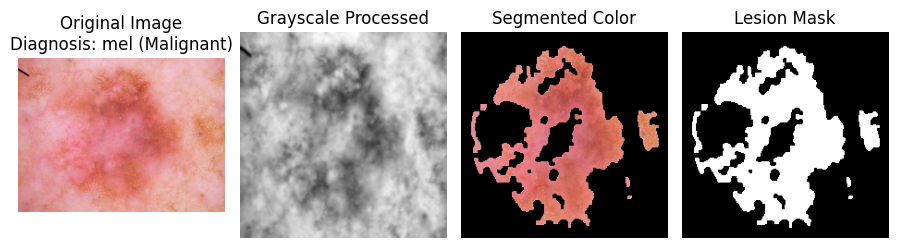


Image Details:
Image ID: ISIC_0026652
Diagnosis: mel (Malignant)
Age: 65.0
Sex: male
Localization: back

Image Details:
Image ID: ISIC_0030583
Diagnosis: bkl (Benign)
Age: 35.0
Sex: female
Localization: trunk


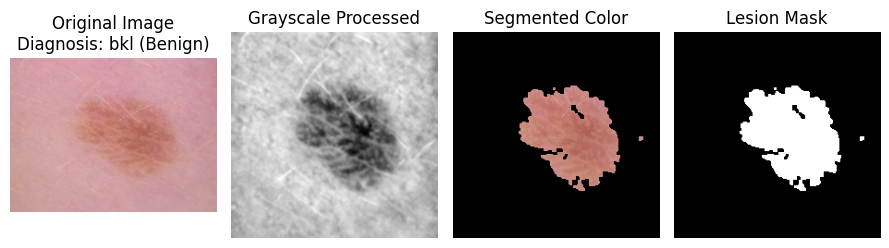


Image Details:
Image ID: ISIC_0030583
Diagnosis: bkl (Benign)
Age: 35.0
Sex: female
Localization: trunk

Image Details:
Image ID: ISIC_0034010
Diagnosis: nv (Benign)
Age: 45.0
Sex: male
Localization: abdomen


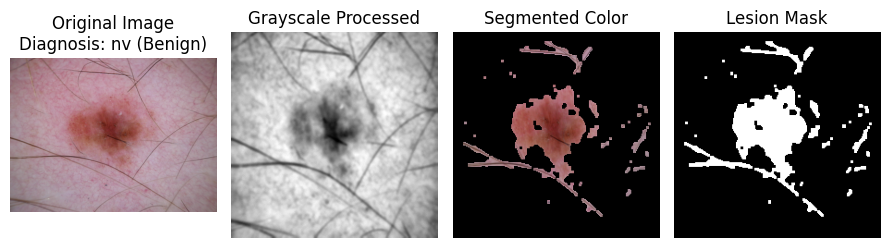


Image Details:
Image ID: ISIC_0034010
Diagnosis: nv (Benign)
Age: 45.0
Sex: male
Localization: abdomen


In [121]:
#-------Test on our Samples-------------
for img_path in sample_image_paths:
    # Load image
    img = load_image(img_path)
    if img is None:
        continue  # Skip if image couldn't be loaded

    # Preprocess
    grey_img, segmented_color, mask = preprocess_image(
        img,
        target_size=TARGET_SIZE,
        target_color_space=TARGET_COLOR_SPACE
    )

    # Get metadata info for display
    image_id = os.path.splitext(os.path.basename(img_path))[0]
    sample_info = df_meta[df_meta['image_id'] == image_id].iloc[0]
    diagnosis = f"{sample_info['dx']} ({'Malignant' if sample_info['malade'] else 'Benign'})"

    # Visualize
    visualize_results(sample_info)

    # Optionally, print details
    image_details(sample_info)




Image Details:
Image ID: ISIC_0024698
Diagnosis: nv (Benign)
Age: 70.0
Sex: male
Localization: face


<Figure size 900x300 with 0 Axes>

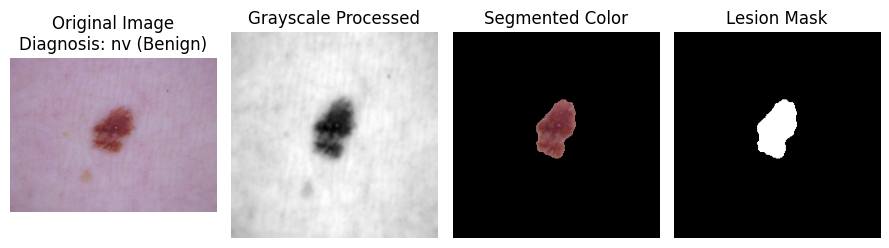


Image Details:
Image ID: ISIC_0025964
Diagnosis: mel (Malignant)
Age: 40.0
Sex: female
Localization: chest


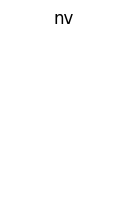

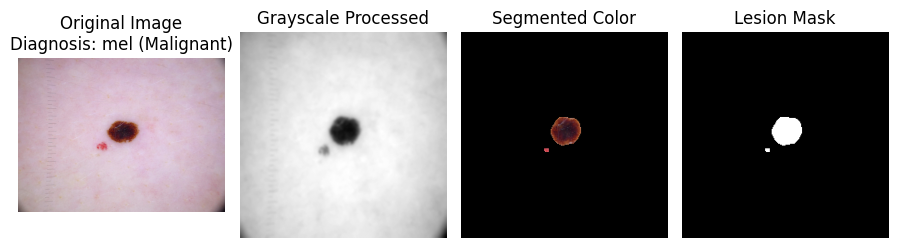


Image Details:
Image ID: ISIC_0027419
Diagnosis: bkl (Benign)
Age: 80.0
Sex: male
Localization: scalp


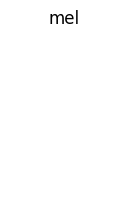

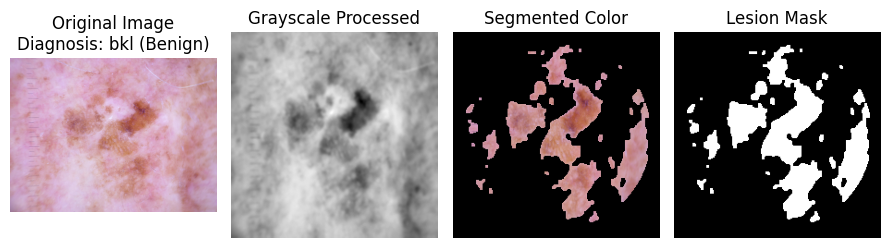


Image Details:
Image ID: ISIC_0028155
Diagnosis: bcc (Malignant)
Age: 50.0
Sex: male
Localization: back


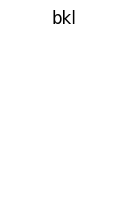

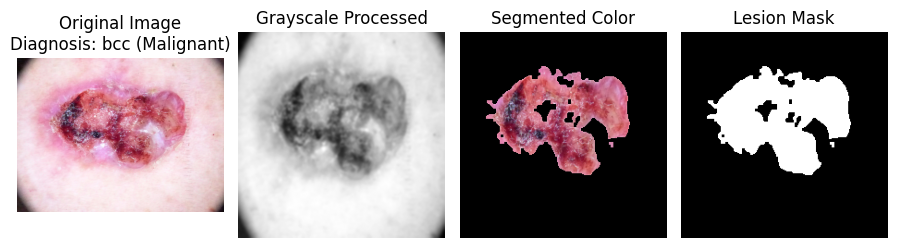


Image Details:
Image ID: ISIC_0029417
Diagnosis: akiec (Malignant)
Age: 80.0
Sex: female
Localization: neck


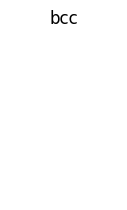

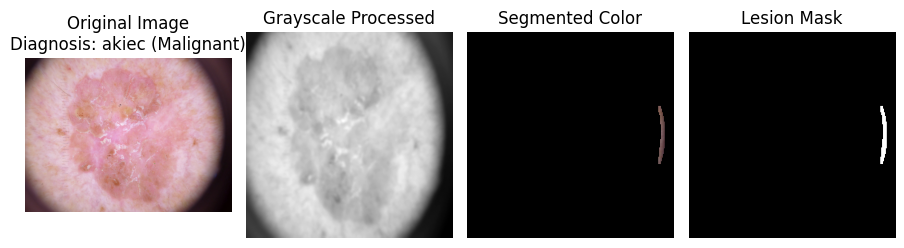


Image Details:
Image ID: ISIC_0031197
Diagnosis: vasc (Benign)
Age: 20.0
Sex: male
Localization: upper extremity


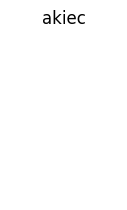

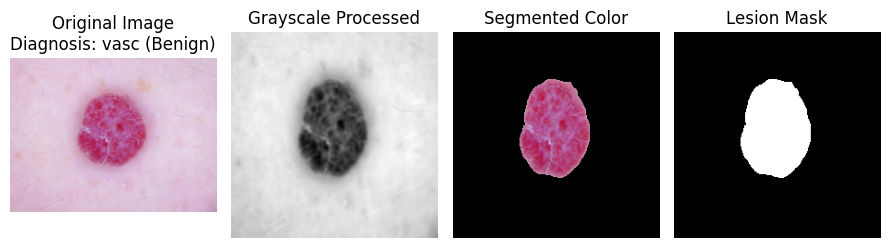


Image Details:
Image ID: ISIC_0027008
Diagnosis: df (Benign)
Age: 75.0
Sex: male
Localization: back


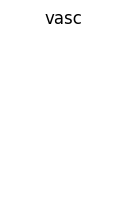

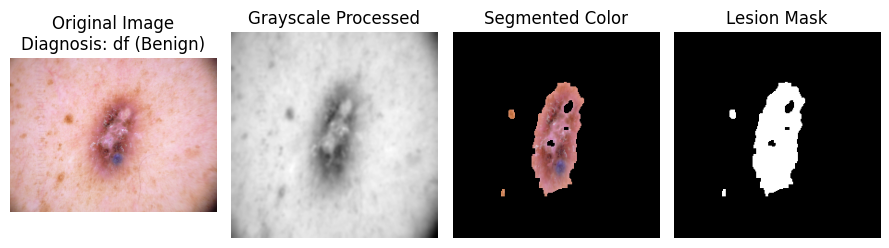

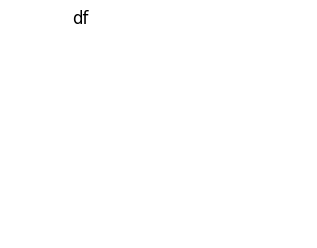

In [66]:
#------- Visualisation of all dx types ---------

plt.figure(figsize=(9, 3))  # Create one figure for all subplots
j = 0

for i in dx_info.keys():
    sample_img = df_meta[df_meta['dx'] == i].iloc[0]
    visualize_results(sample_img)
    j += 1
    plt.subplot(2, 4, j)

    plt.title(i)
    plt.axis("off")

# Optional: turn off the empty 8th subplot
if j < 8:
    for k in range(j + 1, 9):
        plt.subplot(2, 4, k)
        plt.axis("off")

plt.tight_layout()
plt.show()



Image Details:
Image ID: ISIC_0030001
Diagnosis: nv (Benign)
Age: 75.0
Sex: male
Localization: abdomen


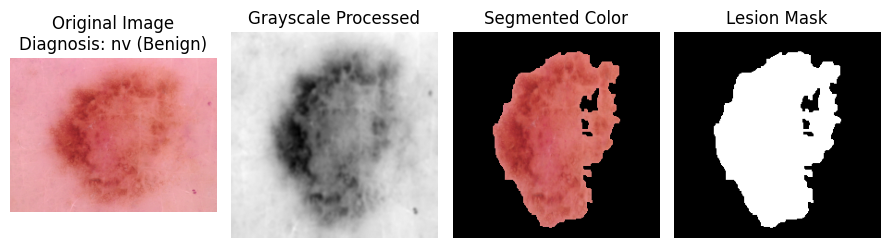

In [77]:
# Main execution
sample_img = df_meta.sample(1).iloc[0]
visualize_results(sample_img)


Image Details:
Image ID: ISIC_0026080
Diagnosis: nv (Benign)
Age: 45.0
Sex: male
Localization: back


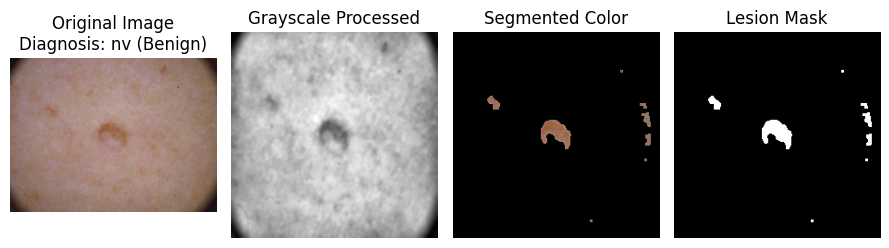

In [120]:
#-------Images with Problems-------------
# Define the target image ID
target_image_id = "ISIC_0026080"

# Select the specific row from the metadata
sample_img = df_meta[df_meta['image_id'] == target_image_id].iloc[0]
visualize_results(sample_img)

#Feature Extraction

Fonctions utiles :

In [116]:
#----------------Fonctions d'extractions de features------------------

def extract_texture_features(gray_img):
    # Convert to 8-bit if needed
    gray_img = (gray_img * 255).astype(np.uint8) if gray_img.max() <= 1.0 else gray_img

    # Définir les angles : 0°, 45°, 90°, 135°
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    angle_labels = ['0°', '45°', '90°', '135°']

    # Calcul du GLCM
    glcm = graycomatrix(gray_img, distances=[1], angles=angles, levels=256, symmetric=True, normed=True)

    # Stocker les features par angle
    features = {
    'contrast': graycoprops(glcm, 'contrast').mean(),
    'homogeneity': graycoprops(glcm, 'homogeneity').mean(),
    'energy': graycoprops(glcm, 'energy').mean(),
    'correlation': graycoprops(glcm, 'correlation').mean(),
    'dissimilarity': graycoprops(glcm, 'dissimilarity').mean()
    }
    return features


def extract_shape_features(mask):
    mask = (mask > 0).astype(np.uint8) * 255  # Assurer que le masque est binaire
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print("Aucun contour trouvé.")
        return {'surface': 0, 'perimeter': 0, 'circularity': 0, 'eccentricity': 0}

    # Prendre le plus grand contour
    c = max(contours, key=cv2.contourArea)

    area = cv2.contourArea(c)
    perimeter = cv2.arcLength(c, True)

    # Circularité : 4πA / P²
    circularity = 4 * np.pi * area / (perimeter**2 + 1e-5)

    # Excentricité via ellipse
    if len(c) >= 5:
        ellipse = cv2.fitEllipse(c)
        (MA, ma) = ellipse[1]  # major, minor axes
        eccentricity = np.sqrt(1 - (min(MA, ma)**2) / (max(MA, ma)**2))
    else:
        eccentricity = 0

    return {
        'surface': area,
        'perimeter': perimeter,
        'circularity': circularity,
        'eccentricity': eccentricity
    }

def extract_color_features(color_img, mask):
    features = {}

    # Assurer que le masque est binaire
    mask = (mask > 0).astype(np.uint8)

    # Convertir en HSV
    hsv_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2HSV)

    # Extraire les canaux H, S, V
    for i, channel_name in enumerate(['H', 'S', 'V']):
        channel = hsv_img[:, :, i]
        values = channel[mask > 0]  # valeurs uniquement dans la lésion

        features[f'{channel_name}_mean'] = np.mean(values)
        features[f'{channel_name}_std'] = np.std(values)

    return features

def extract_features_from_sample( metadata_row, gray_segmented, color_segmented, mask):
    features = {}

        # --- Ajout des features cliniques
    features['age'] = metadata_row['age']
    features['sex'] = 1 if metadata_row['sex'] == 'male' else 0  # sex encodé binaire
    features['localization'] = metadata_row['localization']  # ou one-hot encoder selon les besoins
    features['dx'] = metadata_row['dx']  # diagnostic, à encoder si nécessaire
    features['dx_type'] = metadata_row['dx_type']  # type de diagnostic, à encoder si nécessaire
    features['malade'] = metadata_row['malade']  # 1 ou 0

    # Texture
    features.update(extract_texture_features(gray_segmented))

    # Shape
    features.update(extract_shape_features(mask))

    # Color
    features.update(extract_color_features(color_segmented, mask))

    return features


In [125]:
def analyze_sample_image(sample_img):
    # Path setup
    sample_image_path = f"skin-cancer/HAM10000_images_part_1/{sample_img['image_id']}.jpg"
    if not os.path.exists(sample_image_path):
        sample_image_path = f"skin-cancer/HAM10000_images_part_2/{sample_img['image_id']}.jpg"

    # Load image
    img = load_image(sample_image_path)
    if img is None:
        print(f"Image introuvable : {sample_image_path}")
        return

    # Display metadata
    image_details(sample_img)

    # Preprocessing
    gray_processed, segmented_color, mask = preprocess_image(
        img,
        target_size=TARGET_SIZE,
        target_color_space=TARGET_COLOR_SPACE
    )

    # Generate debug contour image
    mask_bin = (mask > 0).astype(np.uint8) * 255
    contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    debug_img = np.zeros_like(cv2.cvtColor(mask_bin, cv2.COLOR_GRAY2BGR))

    if contours:
        c = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(c)
        hull = cv2.convexHull(c)

        debug_img = cv2.cvtColor(mask_bin, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(debug_img, [c], -1, (0, 255, 0), 2)       # Green
        cv2.rectangle(debug_img, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Blue
        cv2.drawContours(debug_img, [hull], -1, (0, 0, 255), 2)     # Red

    # --- DISPLAY ALL IMAGES IN A ROW ---
    fig, axs = plt.subplots(1, 5, figsize=(18, 4))

    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(gray_processed, cmap='gray')
    axs[1].set_title("Grayscale Processed")
    axs[1].axis('off')

    axs[2].imshow(mask, cmap='gray')
    axs[2].set_title("Lesion Mask")
    axs[2].axis('off')

    axs[3].imshow(cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB))
    axs[3].set_title("Contour Detection")
    axs[3].axis('off')

    axs[4].imshow(cv2.cvtColor(segmented_color, cv2.COLOR_BGR2RGB))
    axs[4].set_title("Segmented Color")
    axs[4].axis('off')

    plt.tight_layout()
    plt.show()

    # --- TEXTURE FEATURES ---
    texture_features = extract_texture_features(gray_processed)
    print("\n🟫 Texture features extracted from grayscale image:")
    for k, v in texture_features.items():
        print(f"  {k}: {v:.4f}")

    # --- SHAPE FEATURES ---
    shape_features = extract_shape_features(mask)
    print("\n🟥 Shape features extracted from lesion mask:")
    for k, v in shape_features.items():
        print(f"  {k}: {v:.4f}")

    # --- COLOR FEATURES ---
    color_features = extract_color_features(segmented_color, mask)
    print("\n🟦 HSV color features extracted from segmented color image:")
    for k, v in color_features.items():
        print(f"  {k}: {v:.4f}")



Image Details:
Image ID: ISIC_0026080
Diagnosis: nv (Benign)
Age: 45.0
Sex: male
Localization: back


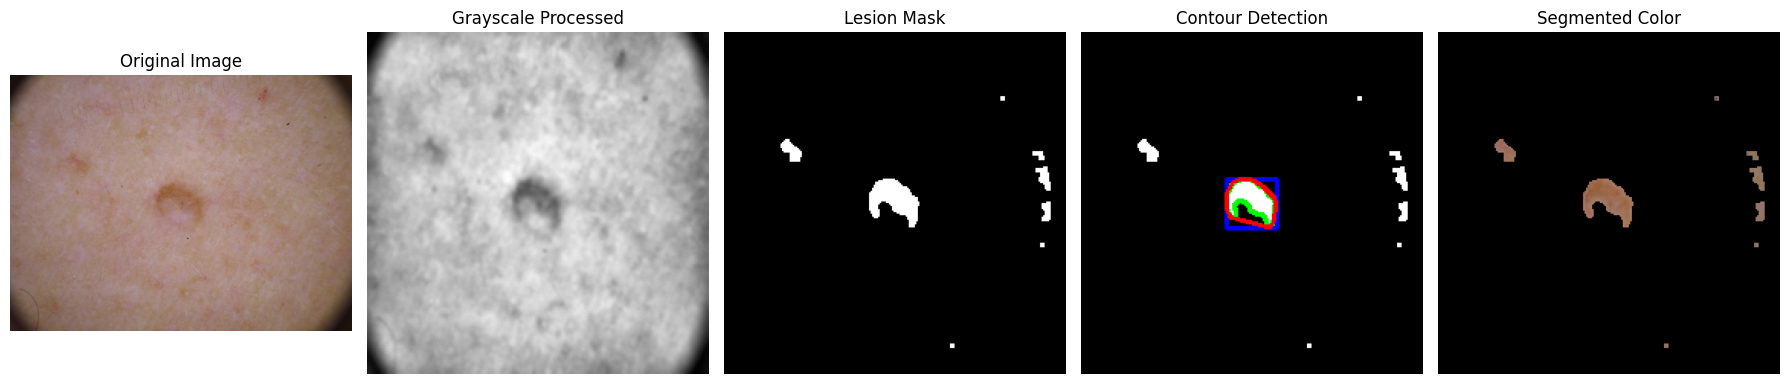


🟫 Texture features extracted from grayscale image:
  contrast: 17.6886
  homogeneity: 0.3098
  energy: 0.0371
  correlation: 0.9867
  dissimilarity: 3.0872

🟥 Shape features extracted from lesion mask:
  surface: 560.0000
  perimeter: 127.7401
  circularity: 0.4313
  eccentricity: 0.6281

🟦 HSV color features extracted from segmented color image:
  H_mean: 10.4483
  H_std: 5.8079
  S_mean: 108.5110
  S_std: 22.6049
  V_mean: 155.9258
  V_std: 7.1700


In [124]:
#---------Testing Feature Extraction----------

# Define the target image ID
target_image_id = "ISIC_0026080"

# Select the specific row from the metadata
sample_img = df_meta[df_meta['image_id'] == target_image_id].iloc[0]

# Select a random row from the metadata
#sample_img = df_meta.sample(1).iloc[0]
analyze_sample_image(sample_img)


Image Details:
Image ID: ISIC_0033272
Diagnosis: mel (Malignant)
Age: 65.0
Sex: male
Localization: face


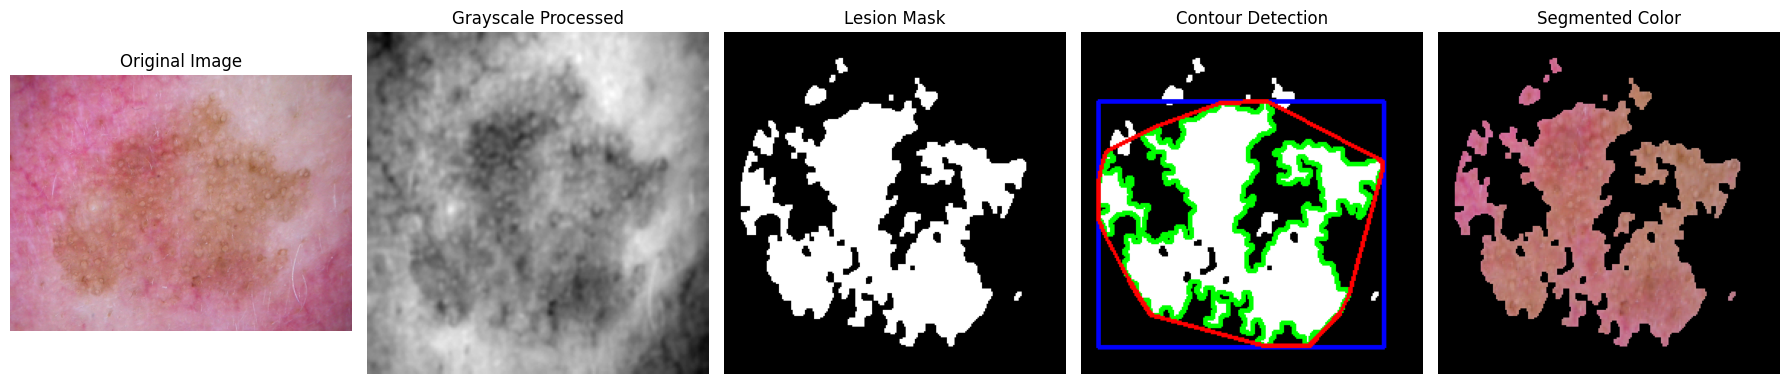


🟫 Texture features extracted from grayscale image:
  contrast: 6.4589
  homogeneity: 0.4096
  energy: 0.0461
  correlation: 0.9885
  dissimilarity: 1.8914

🟥 Shape features extracted from lesion mask:
  surface: 13587.5000
  perimeter: 1655.3839
  circularity: 0.0623
  eccentricity: 0.5896

🟦 HSV color features extracted from segmented color image:
  H_mean: 71.8824
  H_std: 83.4798
  S_mean: 103.9606
  S_std: 13.2253
  V_mean: 188.5222
  V_std: 9.4765

Image Details:
Image ID: ISIC_0031923
Diagnosis: nv (Benign)
Age: 40.0
Sex: female
Localization: lower extremity


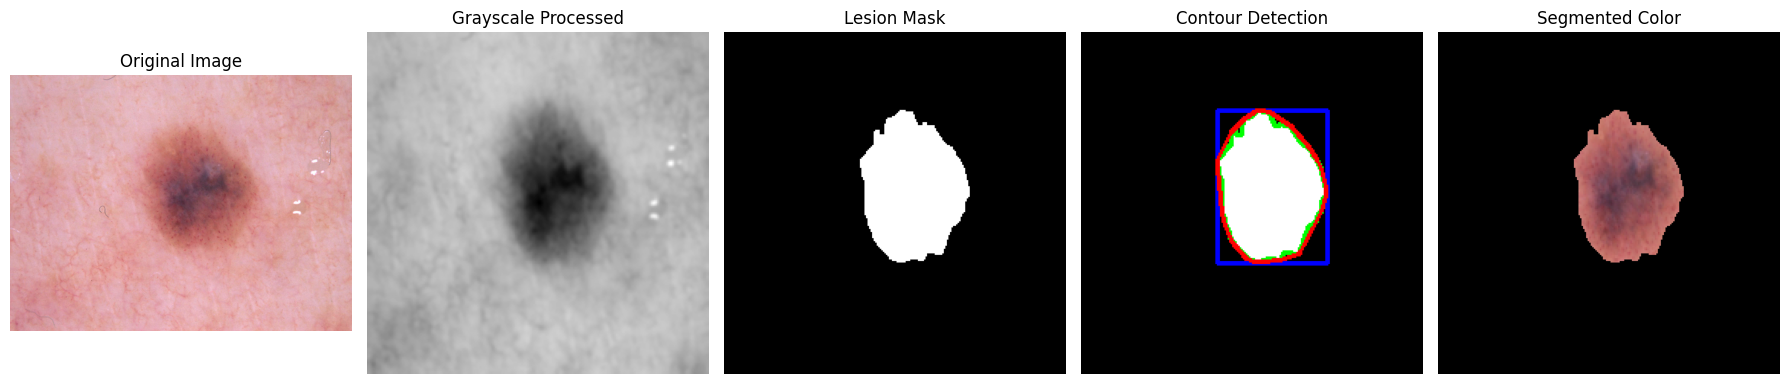


🟫 Texture features extracted from grayscale image:
  contrast: 4.3392
  homogeneity: 0.4928
  energy: 0.0722
  correlation: 0.9961
  dissimilarity: 1.4473

🟥 Shape features extracted from lesion mask:
  surface: 4991.0000
  perimeter: 300.1076
  circularity: 0.6964
  eccentricity: 0.6844

🟦 HSV color features extracted from segmented color image:
  H_mean: 90.5401
  H_std: 86.6014
  S_mean: 113.0100
  S_std: 9.8929
  V_mean: 162.6321
  V_std: 31.1930

Image Details:
Image ID: ISIC_0026652
Diagnosis: mel (Malignant)
Age: 65.0
Sex: male
Localization: back


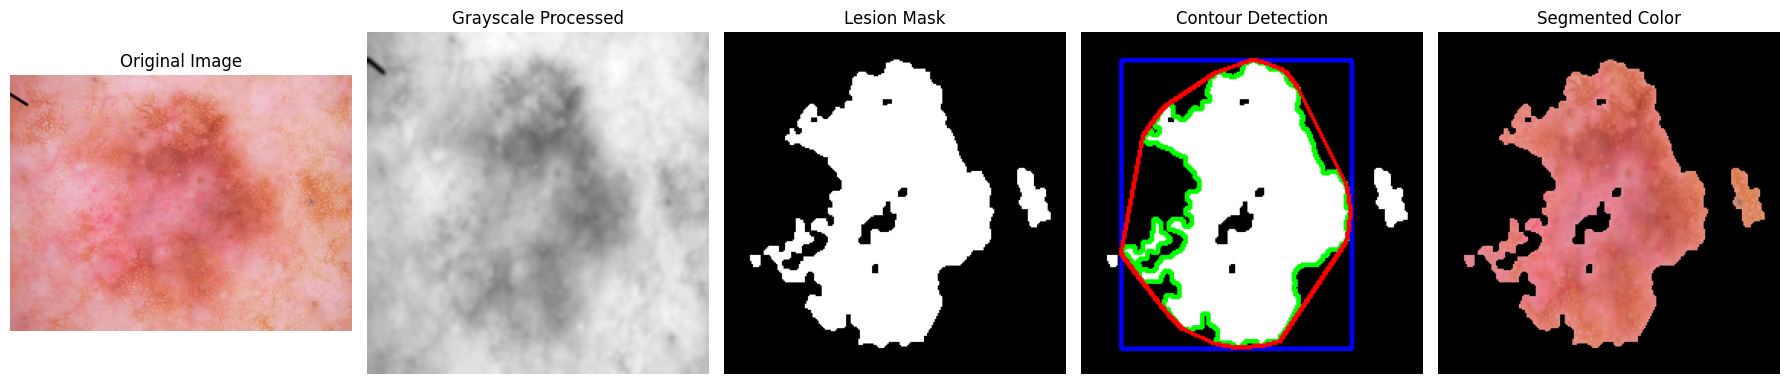


🟫 Texture features extracted from grayscale image:
  contrast: 6.7724
  homogeneity: 0.4313
  energy: 0.0441
  correlation: 0.9922
  dissimilarity: 1.7671

🟥 Shape features extracted from lesion mask:
  surface: 15793.0000
  perimeter: 893.0092
  circularity: 0.2489
  eccentricity: 0.6996

🟦 HSV color features extracted from segmented color image:
  H_mean: 55.7277
  H_std: 79.8073
  S_mean: 129.6855
  S_std: 16.0862
  V_mean: 217.9392
  V_std: 11.8524

Image Details:
Image ID: ISIC_0030583
Diagnosis: bkl (Benign)
Age: 35.0
Sex: female
Localization: trunk


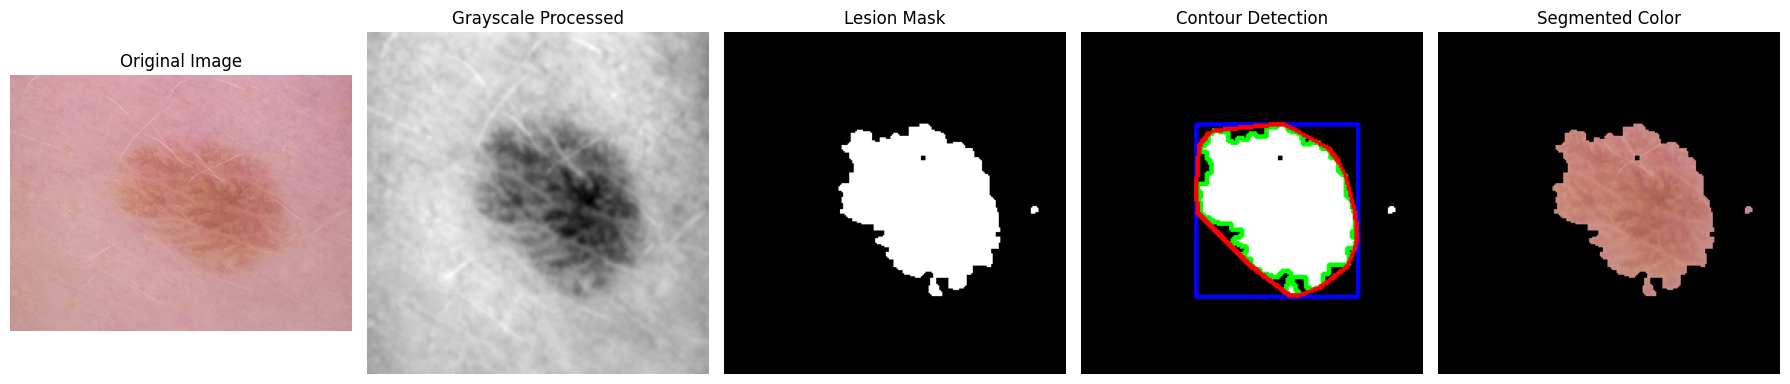


🟫 Texture features extracted from grayscale image:
  contrast: 1.8468
  homogeneity: 0.6241
  energy: 0.1053
  correlation: 0.9929
  dissimilarity: 0.9173

🟥 Shape features extracted from lesion mask:
  surface: 7634.5000
  perimeter: 476.6346
  circularity: 0.4223
  eccentricity: 0.6755

🟦 HSV color features extracted from segmented color image:
  H_mean: 8.0887
  H_std: 26.2789
  S_mean: 103.2428
  S_std: 11.3577
  V_mean: 195.3072
  V_std: 7.3478

Image Details:
Image ID: ISIC_0034010
Diagnosis: nv (Benign)
Age: 45.0
Sex: male
Localization: abdomen


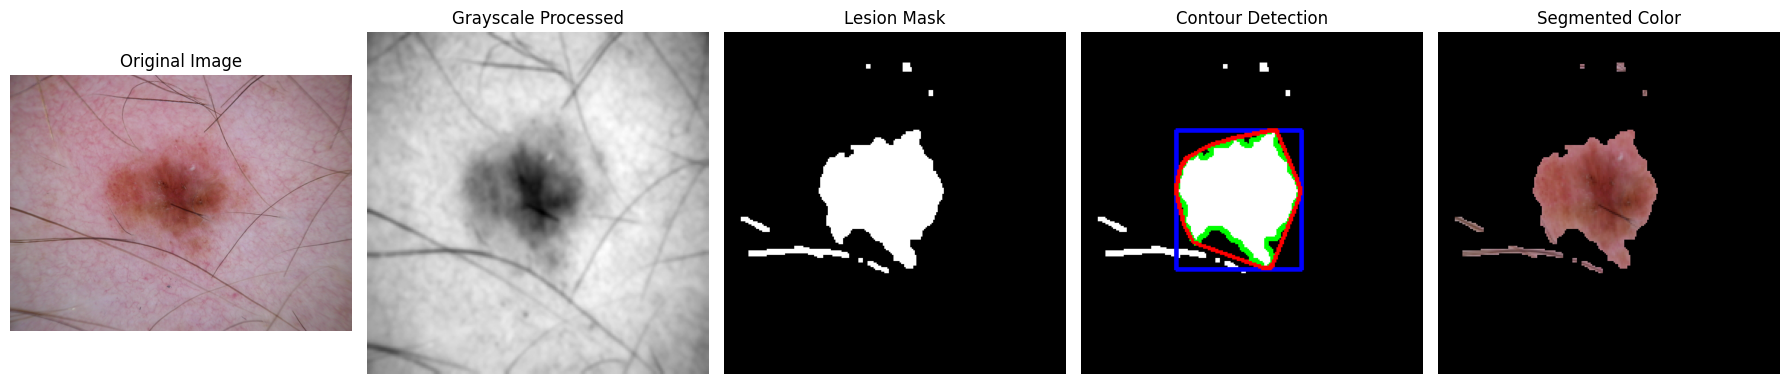


🟫 Texture features extracted from grayscale image:
  contrast: 9.7467
  homogeneity: 0.4157
  energy: 0.0508
  correlation: 0.9869
  dissimilarity: 2.0633

🟥 Shape features extracted from lesion mask:
  surface: 4499.5000
  perimeter: 333.6640
  circularity: 0.5079
  eccentricity: 0.2836

🟦 HSV color features extracted from segmented color image:
  H_mean: 55.5322
  H_std: 80.2846
  S_mean: 116.9933
  S_std: 30.5514
  V_mean: 154.4833
  V_std: 20.1108


In [115]:
#-------Test on our Samples-------------
for img_path in sample_image_paths:
    # Load image
    img = load_image(img_path)
    if img is None:
        continue  # Skip if image couldn't be loaded

    # Preprocess
    grey_img, segmented_color, mask = preprocess_image(
        img,
        target_size=TARGET_SIZE,
        target_color_space=TARGET_COLOR_SPACE
    )

    # Get metadata info for display
    image_id = os.path.splitext(os.path.basename(img_path))[0]
    sample_info = df_meta[df_meta['image_id'] == image_id].iloc[0]
    diagnosis = f"{sample_info['dx']} ({'Malignant' if sample_info['malade'] else 'Benign'})"

    # Visualize
    analyze_sample_image(sample_info)



#Data Processing

In [ ]:

def prepare_ml_data(df, target_col='malade', scale=True, test_size=0.2, val_size=0.1, random_state=42):
    df = df.copy()

    # 1. Suppression des lignes avec valeurs manquantes
    df = df.dropna()

    # 2. Encodage des colonnes catégorielles
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    if target_col in cat_cols:
        cat_cols.remove(target_col)

    df = pd.get_dummies(df, columns=cat_cols)

    # 3. Séparation X / y
    y = df[target_col]
    X = df.drop(columns=[target_col])

    # 4. Standardisation
    scaler = None
    if scale:
        scaler = StandardScaler()
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # 5. Split train/val/test
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=(test_size + val_size), stratify=y, random_state=random_state)

    relative_val_size = val_size / (test_size + val_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=relative_val_size, stratify=y_temp, random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler


In [ ]:
import pandas as pd
import numpy as np

# Création d'un DataFrame fictif
data = {
    'age': [30, 45, 60, 33, 50, 41, 29, 67, 48, 55],
    'sex': ['male', 'female', 'female', 'male', 'female', 'male', 'male', 'female', 'male', 'female'],
    'localization': ['face', 'trunk', 'back', 'leg', 'face', 'trunk', 'trunk', 'face', 'arm', 'leg'],
    'contrast': np.random.rand(10),
    'homogeneity': np.random.rand(10),
    'surface': np.random.randint(1000, 2000, 10),
    'perimeter': np.random.rand(10) * 100,
    'H_mean': np.random.rand(10) * 100,
    'S_std': np.random.rand(10) * 10,
    'malade': [0, 1, 1, 0, 1, 0, 0, 1, 0, 1],  # Target (0: sain, 1: malade)
}

df = pd.DataFrame(data)

# Utilisation de la fonction
X_train, X_val, X_test, y_train, y_val, y_test, scaler = prepare_ml_data(df)

# Vérification
print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

print("\nExemple de X_train :\n", X_train.head())
print("\nExemple de y_train :\n", y_train.head())
